# Mini Project2


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from surprise import SVD
from surprise import accuracy, Dataset, Reader

In [21]:
url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [22]:
data = np.array(pd.read_csv('data.csv'))
movies = np.array(pd.read_csv('movies.csv'))
train = np.array(pd.read_csv('train.csv'))
test = np.array(pd.read_csv('test.csv'))

## Surprise - setup

In [23]:
M = max(max(train[:,0]), max(test[:,0])).astype(int) # users
N = max(max(train[:,1]), max(test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

# reader for range of ratings
reader = Reader(rating_scale=(1,5))

# convert train numpy array to data frame
train_df = pd.DataFrame(train, columns= ['User ID', 'Movie ID', 'Rating'])

# create surprise data object
train_ds = Dataset.load_from_df(train_df[['User ID','Movie ID', 'Rating']], reader)

# convert to train set
train_ts = train_ds.build_full_trainset()
train_ts.n_users = M # specify number of users
train_ts.n_items = N # specify number of items

Factorizing with  943  users,  1682  movies.


## Study regularization - no bias

Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.0001
RMSE: 0.6195
RMSE: 1.0845
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.0003727593720314938
RMSE: 0.6233
RMSE: 1.0633
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.0013894954943731374
RMSE: 0.6241
RMSE: 1.0610
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.005179474679231213
RMSE: 0.6231
RMSE: 1.0556
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.019306977288832496
RMSE: 0.6382
RMSE: 1.0195
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.07196856730011514
RMSE: 0.7228
RMSE: 0.9526
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.2682695795279725
RMSE: 0.9900
RMSE: 1.0163
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 1.0
RMSE: 1.3994
RMSE: 1.4129


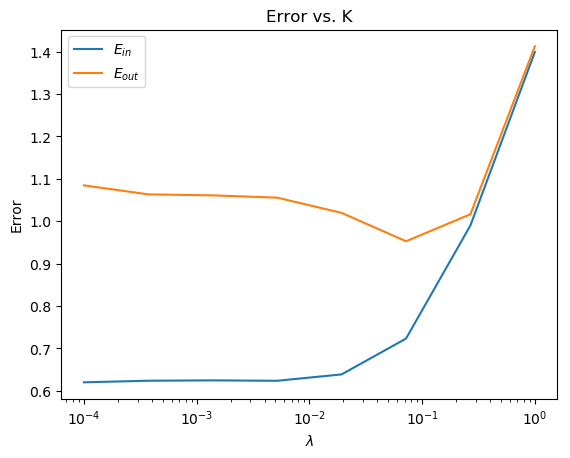

In [24]:
regs = np.logspace(-4,0,8)
eta = 0.03 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
for reg in regs:
    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
    algo = SVD(n_factors=K,biased=False,lr_all=eta,reg_all=reg)
    algo.fit(train_ts)
    predictions_train = algo.test(train)
    predictions_test = algo.test(test)
    E_in.append(accuracy.rmse(predictions_train))
    E_out.append(accuracy.rmse(predictions_test))

plt.semilogx(regs, E_in, label='$E_{in}$')
plt.semilogx(regs, E_out, label='$E_{out}$')
plt.title('Error vs. K')
plt.xlabel(r'$\lambda$')
plt.ylabel('Error')
plt.legend()
plt.savefig('surprise.png')

## Study regularization - with bias

Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.0001
RMSE: 0.5620
RMSE: 1.0432
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.0003727593720314938
RMSE: 0.5625
RMSE: 1.0516
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.0013894954943731374
RMSE: 0.5617
RMSE: 1.0401
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.005179474679231213
RMSE: 0.5664
RMSE: 1.0415
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.019306977288832496
RMSE: 0.5838
RMSE: 0.9920
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.07196856730011514
RMSE: 0.6873
RMSE: 0.9175
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.2682695795279725
RMSE: 0.9313
RMSE: 0.9504
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 1.0
RMSE: 0.9761
RMSE: 0.9863


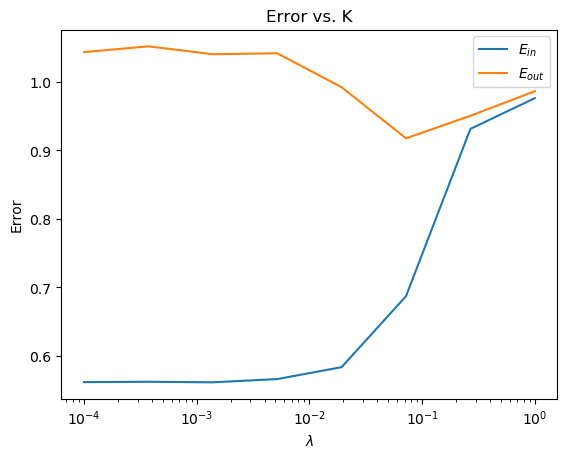

In [25]:
regs = np.logspace(-4,0,8)
eta = 0.03 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
for reg in regs:
    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
    algo = SVD(n_factors=K,biased=True,lr_all=eta,reg_all=reg)
    algo.fit(train_ts)
    predictions_train = algo.test(train)
    predictions_test = algo.test(test)
    E_in.append(accuracy.rmse(predictions_train))
    E_out.append(accuracy.rmse(predictions_test))

plt.semilogx(regs, E_in, label='$E_{in}$')
plt.semilogx(regs, E_out, label='$E_{out}$')
plt.title('Error vs. K')
plt.xlabel(r'$\lambda$')
plt.ylabel('Error')
plt.legend()
plt.savefig('surprise.png')

## Get final model

In [26]:
algo = SVD(n_factors=K,biased=False,lr_all=eta,reg_all=1e-1)
algo.fit(train_ts)
predictions_train = algo.test(train)
predictions_test = algo.test(test)
accuracy.rmse(predictions_train)
accuracy.rmse(predictions_test)

# extract matrix
U = algo.pu
V = algo.qi
print("U is matrix of size ",U.shape[0]," by ",U.shape[1])
print("V is matrix of size ",V.shape[0]," by ",V.shape[1])

RMSE: 0.7888
RMSE: 0.9447
U is matrix of size  943  by  20
V is matrix of size  1682  by  20
